# Introduction to cellstates

`cellstates` is a python package for analysis of UMI-based single-cell RNA-seq data. The underlying mathematical model infers clusters of cells that are in the same gene expression state, meaning that all remaining heterogeneity within each cluster can be explained by expected measurement noise. Thus, we find the most fine-grained clustering that is  supported by the data. Furthermore, we describe the higher-order relationship of these cell-states in a hierarchical tree and provide scores for marker-genes within this tree.

Instruction on how to install and run `cellstates` on the commandline can be found in the [Readme](../README.md)

# Python module

Some more advanced functionalities of cellstates can currently only be accessed by running cellstates through python or by loading the output files of the commandline tool into python. 

In [1]:
import cellstates as cs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load data

datafile = '../test/data/simulated_data.tsv.gz'
df = pd.read_csv(datafile, sep='\t', index_col=0)

data = df.values.astype(np.int)
all_genes = df.index.values
cells = df.columns.values

G, N = data.shape
G, N

(19052, 2298)

The information about a dataset is stored in a `cs.Cluster` object. 

In [3]:
help(cs.Cluster)

Help on class Cluster in module cellstates.cluster:

class Cluster(builtins.object)
 |  Object that contains SC expression data, lambda and stores a partition
 |  
 |  Parameters
 |  ----------
 |  d : 2D array of ints
 |      UMI count array of shape (N_genes, N_cells)
 |  l : 1D array or float, default=None
 |      If array, the pseudo-counts lambda for each gene. Has to be of shape (N_genes, ).
 |      All entries must be > 0. If float, defines the magnitude of the pseudo-counts,
 |      but their relative sizes is set by data average. If None, magnitude is chosen
 |      automatically.
 |  c : 1D array of ints, default=None
 |      Cluster labels for each cell. Has to be of shape (N_cells, ).
 |      Labels must be positive and < N_boxes. If None, every cell is in its own cluster.
 |  genes : 1D array, optional
 |      Names of genes; does not have to be set.
 |  max_clusters : int, default 0
 |      Maximum number of clusters allowed (acces through item N_boxes).
 |      if max_cl

In [4]:
# creating a new object with default settings
clst = cs.Cluster(data)

The object stores a partition of the cells into cellstates (accessed through `clst.clusters`). By default, each cell is in its own cellstate.

In [5]:
clst.clusters

array([   0,    1,    2, ..., 2295, 2296, 2297])

## Optimization of partition
**NOTE:** The full optimization of both the partition and the prior is currently only implemented in the commandline tool. Only optimize the partition through python if you understand the mathematical model. 

The aim is to find the partition that maximises the log-likelihood of our model. 
The mathematical model has three inputs: The data, the partition and a set of prior parameters (automatically chosen by default and accessed through `clst.dirichlet_pseudocounts`) and returns a likelihood.
Thus, changing the partition changes the likelihood.

In [6]:
print(clst.total_likelihood)

-83483186.21598652


In [7]:
clst.move_cell(0, 1) # move cell 0 into cluster 1
print(clst.clusters)
print(clst.total_likelihood) # likelihood changed

[   1    1    2 ... 2295 2296 2297]
-83483068.42137566


To efficiently optimize the likelihood, we need to initialize the `cs.Cluster` object with multiple threads and a large cache.  

In [8]:
clst = cs.Cluster(data, num_threads=8, n_cache=1000)

An Markov-chain Monte Carlo algorithm is used to optimize likelihood as a function of the partition with a given prior. This will change the partition and the likelihood.

In [9]:
clst.biased_monte_carlo_sampling(N_steps=500, tries_per_step=100)

In [10]:
print(clst.clusters[:10])
clst.total_likelihood

[ 0  1 33  3  4  5  6  7  8 15]


-83412038.52364226

For the full optimization run, the sampling is repeatedly called. At the end, there are also deterministic optimization steps (merging clusters, moving cells into their optimal cluster). This might take a couple of minutes to run. 

In [11]:
cs.run_mcmc(clst, N_steps=500)

2021-09-17 17:38:56,267 - INFO:initially check output every 500 steps
2021-09-17 17:38:56,268 - INFO:n_clusters=1938, total likelihood=-83412038.52364226
2021-09-17 17:39:05,847 - INFO:n_clusters=1692, total likelihood=-83318483.61374699
2021-09-17 17:39:16,047 - INFO:n_clusters=1442, total likelihood=-83188467.43220574
2021-09-17 17:39:29,344 - INFO:n_clusters=1180, total likelihood=-83028671.37830295
2021-09-17 17:39:42,424 - INFO:n_clusters=925, total likelihood=-82860456.8142258
2021-09-17 17:39:56,630 - INFO:n_clusters=697, total likelihood=-82691998.59724334
2021-09-17 17:40:09,231 - INFO:n_clusters=513, total likelihood=-82547930.50152539
2021-09-17 17:40:21,002 - INFO:n_clusters=348, total likelihood=-82387993.71254687
2021-09-17 17:40:30,720 - INFO:n_clusters=220, total likelihood=-82242715.9727039
2021-09-17 17:40:38,346 - INFO:n_clusters=155, total likelihood=-82131773.3551481
2021-09-17 17:40:45,540 - INFO:n_clusters=102, total likelihood=-82010692.70394996
2021-09-17 17:40

In [12]:
print(clst.total_likelihood)
print(clst.n_clusters)

-81457510.71362096
9


comparison to true cluster labels shows a slight disagreement

In [13]:
from sklearn.metrics import adjusted_rand_score
cellstate_clusters = clst.clusters
sim_clusters = np.loadtxt('../test/data/simulated_clusters.txt', dtype=int)
adjusted_rand_score(sim_clusters, cellstate_clusters)

0.9811421746094137

However, when we calculate the likelihood of the true clusters, we see that it is actually smaller. This can one of means that under the current prior, the data is insufficient to resolve two of the simulated cellstates. However, with a different prior we might get a higher likelihood and sufficient resolution. 


In [14]:
best_likelihood = clst.total_likelihood
clst.set_clusters(sim_clusters)  # change partition to simulated one
print(best_likelihood - clst.total_likelihood)  # compute difference in log-likelihood to optimal solution

830.9129016399384


## Analysing the model outputs

From the root directory, you can run

`python scripts/run_cellstates.py test/data/simulated_data.tsv.gz -o test/results/`

or simply use the example outputs already provided. 

In [15]:
# build cs.Cluster object from model outputs
# These may be different from the earlier results since the prior also got optimized
prior = np.loadtxt('../test/results/dirichlet_pseudocounts.txt')
clusters = np.loadtxt('../test/results/optimized_clusters.txt', dtype=np.int)

# cellstates filters out non-expressed genes, so we need to take that into account
# If you want to check, you can look at the columns of hierarchy_gene_scores.tsv
genes = df.index[df.any(1)].values
data = df.loc[genes].values 

clst = cs.Cluster(data, prior, clusters)

Basic statistics like cluster sizes can easily be checked

In [16]:
print(clst.n_clusters)  # number of cellstates
clst.cluster_sizes[:10]

10


array([ 41,  28, 118, 200, 836, 109, 255, 138, 457, 116])

In [17]:
# perform PCA for visualization
from sklearn.decomposition import PCA

# calculate transcripts per median UMI count per cell
scale_factor = np.median(data.sum(0))

tpm_data = scale_factor*data/data.sum(0)
X = np.log2(tpm_data + 1).T
pca = PCA(n_components=16)
pca.fit(X)
X_pca = pca.transform(X)

pca.explained_variance_ratio_

array([0.06938859, 0.02399711, 0.0206031 , 0.0154975 , 0.00768115,
       0.00556578, 0.00473145, 0.0037067 , 0.00195545, 0.00111253,
       0.00110936, 0.00109254, 0.00107697, 0.00107225, 0.00106489,
       0.00105527])

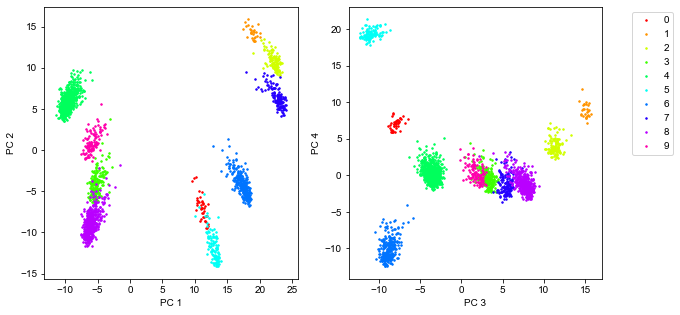

In [18]:
def plot_pca(clusters, pc=None):
    """
    pc: list of 4 principle components to plot
    """
    cluster_names = np.unique(clusters)
    n_c = len(cluster_names)
    colors = dict(zip(cluster_names, plt.cm.hsv(np.linspace(0, 1, n_c+1))))
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    
    if pc is None:
        pc = [1,2,3,4]
    for i, ax in enumerate(axs.flatten()):
        c1 = pc[2*i]
        c2 = pc[2*i+1]
        
        x = X_pca[:, c1-1]
        y = X_pca[:, c2-1]
        for c in cluster_names:
            cond = clusters==c
            ax.plot(x[cond], y[cond], '.', ms=3, label=c, color=colors[c])


        ax.set_xlabel(f'PC {c1}')

        ax.set_ylabel(f'PC {c2}')
    l = plt.legend(ncol=1)
    l.set_bbox_to_anchor([1.3, 1])
    
    return fig, axs

fig,axs = plot_pca(clst.clusters)

### Hierarchical merging of clusters
* in every step we are looking for the two clusters that when merged result in the smallest change in LL

In [19]:
# The code below shows how to get the cluster hierarchy from a Cluster object
# this is not necessary if you ran the command line tool
cluster_hierarchy, delta_LL_history = clst.get_cluster_hierarchy()

print(cluster_hierarchy)
print(delta_LL_history)
hierarchy_df = cs.get_hierarchy_df(cluster_hierarchy, delta_LL_history)
hierarchy_df

[(2, 7), (1, 2), (0, 5), (3, 9), (3, 8), (0, 6), (0, 1), (3, 4), (0, 3)]
[-2799.456104805693, -25175.80503667146, -33563.930881099775, -79185.75470018387, -130431.41800406575, -130947.26361367106, -265458.8526605107, -429146.7600688189, -1083290.4226034284]


,cluster_new,cluster_old,delta_LL
0,2,7,-2.799456e+03
1,1,2,-2.517581e+04
2,0,5,-3.356393e+04
3,3,9,-7.918575e+04
4,3,8,-1.304314e+05
5,0,6,-1.309473e+05
6,0,1,-2.654589e+05
7,3,4,-4.291468e+05
8,0,3,-1.083290e+06


In [20]:
# to load the same results from the command line tool output run
hierarchy_df = pd.read_csv('../test/results/cluster_hierarchy.tsv', sep='\t')
hierarchy_df

,cluster_new,cluster_old,delta_LL
0,2,7,-2.799456e+03
1,1,2,-2.517581e+04
2,0,5,-3.356393e+04
3,3,9,-7.918575e+04
4,3,8,-1.304314e+05
5,0,6,-1.309473e+05
6,0,1,-2.654589e+05
7,3,4,-4.291468e+05
8,0,3,-1.083290e+06


The module contains functions that can transform these trees into **other formats**:
* scipy linkage matrix: 
    * integrated into python
    * only allows one leaf per cluster
    * only positive distances allowed
    
* Newick format
    * widely used for phylogenetic trees with plotting libraries available
    * allows for one leaf per cell
    * only positive distances allowed in plotting tool I use

In [21]:
# scipy linkage matrix
Z = cs.get_scipy_hierarchy(hierarchy_df)
Z

array([[2.00000000e+00, 7.00000000e+00, 2.79945610e+03, 9.00000000e+00],
       [1.00000000e+00, 1.00000000e+01, 2.51758050e+04, 1.00000000e+01],
       [0.00000000e+00, 5.00000000e+00, 3.35639309e+04, 5.00000000e+00],
       [3.00000000e+00, 9.00000000e+00, 7.91857547e+04, 1.20000000e+01],
       [8.00000000e+00, 1.30000000e+01, 1.30431418e+05, 2.00000000e+01],
       [6.00000000e+00, 1.20000000e+01, 1.30947264e+05, 1.10000000e+01],
       [1.10000000e+01, 1.50000000e+01, 2.65458853e+05, 2.10000000e+01],
       [4.00000000e+00, 1.40000000e+01, 4.29146760e+05, 2.40000000e+01],
       [1.60000000e+01, 1.70000000e+01, 1.08329042e+06, 4.50000000e+01]])

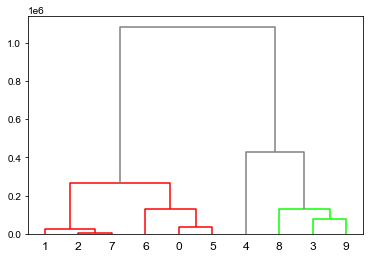

In [22]:
# simple plotting built into cellstate library
R = cs.plot_hierarchy_scipy(hierarchy_df, n_groups=3)

Create a newick string from the hierarchy and use it to generate a Tree in ete3. Check their documentation 

In [35]:
from ete3 import Tree
newick_string = cs.hierarchy_to_newick(hierarchy_df, clst.clusters, cell_leaves=False)
t = Tree(newick_string, format=1)

node = t.search_nodes(name="I2")[0]
print(node)


         /-C0
      /-|
   /-|   \-C5
  |  |
--|   \-C6
  |
  |   /-C1
   \-|
     |   /-C2
      \-|
         \-C7


In the newick format, internal nodes are labelled I0 (root), I1, etc. from the root towards the leaves, following the hierarchy. Cellstate nodes are called C0, C1, ... corresponding to cellstates 0, 1, ... - cells can be included as leaves branching off each cellstate node

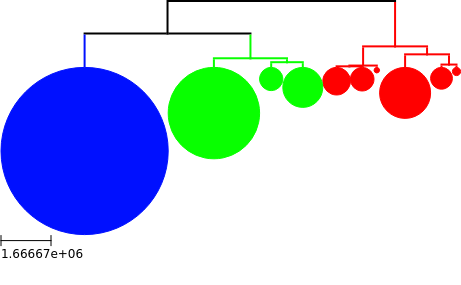

In [25]:
# this built-in function automatically generates a tree visualization with ete3
t, ts = cs.plot_hierarchy_ete3(hierarchy_df, clst.clusters, n_groups=3)
t.render('%%inline', tree_style=ts)

### Finding marker genes

In [26]:
# Scores can be calculated in python from a new Cluster object
score_table = cs.marker_score_table(clst, hierarchy_df)

score_df = pd.concat([hierarchy_df, pd.DataFrame(score_table, columns=genes)], axis=1)
score_df


,cluster_new,cluster_old,delta_LL,A1BG_AS1__chr19,A1BG__chr19,A1CF__chr10,A2M_AS1__chr12,A2ML1__chr12,A2M__chr12,A4GALT__chr22,...,ZWILCH__chr15,ZWINT__chr10,ZXDA__chrX,ZXDB__chrX,ZXDC__chr3,ZYG11A__chr1,ZYG11B__chr1,ZYX__chr7,ZZEF1__chr17,ZZZ3__chr1
0,2,7,-2.799456e+03,0.020978,-0.833928,-4.097787,0.090904,-0.553319,0.692268,-2.290200,...,-3.736366,-1.898122,0.625673,-1.325193,0.987170,-0.647077,0.931867,-2.988756,-0.025758,1.092095
1,1,2,-2.517581e+04,0.015103,0.029758,0.944315,0.065448,-0.083293,0.498413,1.775488,...,1.063568,-1.362457,0.183085,-0.400897,-0.951313,-0.068190,0.652736,-4.106410,0.760226,0.602497
2,0,5,-3.356393e+04,-0.577670,-0.316157,0.754456,1.283495,-1.157468,-0.354913,2.342907,...,0.310090,1.520328,-0.224845,-1.771573,0.811921,-1.142381,0.003548,2.375422,0.940258,0.294136
3,3,9,-7.918575e+04,-0.429912,0.552952,1.090215,2.097459,-1.842929,-0.199278,0.159641,...,0.405705,1.072406,-2.297589,1.321008,-5.575027,-0.868250,-3.318299,-0.044810,1.293571,-0.271182
4,3,8,-1.304314e+05,-0.845864,1.950113,-4.793532,2.632477,2.194281,0.150400,-0.304482,...,-2.619545,1.246846,1.670861,1.808500,-17.422929,2.143558,1.327588,1.519087,1.667097,1.330079
5,0,6,-1.309473e+05,-1.840757,-1.411845,5.107918,1.146656,-0.866764,-84.390837,2.102743,...,1.586677,-0.444337,0.781690,-2.347762,-0.669711,2.289888,1.447928,1.278904,-0.284174,1.268041
6,0,1,-2.654589e+05,-1.019280,1.281189,-31.262817,-1.969078,2.391240,-50.422215,1.560356,...,1.427620,2.112162,-0.134988,0.854948,1.059080,2.138729,-6.050198,-8.489755,-1.761583,1.153228
7,3,4,-4.291468e+05,-0.681373,2.215166,-77.011544,-0.968587,3.032097,0.538588,-0.452631,...,1.390780,2.032147,1.819506,0.095413,1.809440,2.713217,-4.142683,-0.456283,-5.982035,-4.250121
8,0,3,-1.083290e+06,2.622894,-6.338706,-176.026848,2.913281,2.993136,-112.351032,-18.653126,...,-7.054857,-2.983890,-5.550374,1.853181,-13.315322,2.903584,2.128409,-156.590250,1.692591,-10.021624


In [27]:
# Alternatively, load results from a previous run
score_df = pd.read_csv('../test/results/hierarchy_gene_scores.tsv', sep='\t')
gene_scores = score_df.iloc[:, 3:]

The scores allow you to check which genes were important in each step of the hierarchy. 
The following analysis shows the important genes for the second to last merge (clusters 3 and 4 get merged). 

In [28]:
n_groups = 3  # number of clusters left at the point we consider in the hierarchy, before the merge
n_merges = hierarchy_df.shape[0]
n_steps = n_merges - n_groups + 1

n_top = 20  # number of top genes considered
gene_importance_order = np.argsort(gene_scores.loc[n_steps])
top_genes = genes[gene_importance_order[:n_top]]
top_genes

array(['GCG__chr2', 'TTR__chr18', 'SST__chr3', 'PPY__chr17', 'INS__chr11',
       'IAPP__chr12', 'RBP4__chr10', 'CHGB__chr20', 'ALDH1A1__chr9',
       'TM4SF4__chr3', 'GC__chr4', 'PCSK2__chr20', 'MALAT1__chr11',
       'PCSK1__chr5', 'FTH1__chr11', 'VGF__chr7', 'LOXL4__chr10',
       'HADH__chr4', 'FTL__chr19', 'SCG2__chr2'], dtype=object)

We can also find the clusters at this point in the hierarchy:

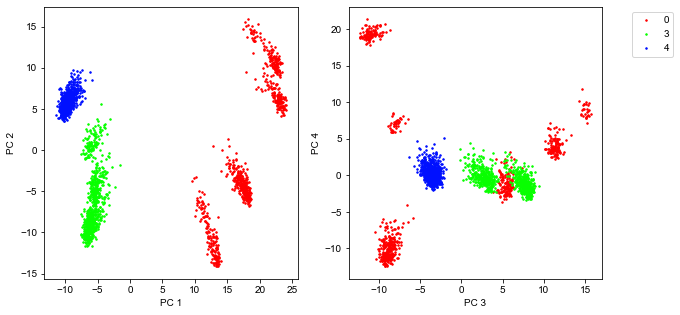

In [29]:
merged_clusters = cs.clusters_from_hierarchy(hierarchy_df, clst.clusters.copy(), n_steps)
fig, axs = plot_pca(merged_clusters)

Next, we find the inferred gene expression states of the higher-order clusters before the merge. We can choose either to get modal values (`get_expressionstate`) or mean and variance (`get_expressionstate_mv`)

In [30]:
merged_clusters = cs.clusters_from_hierarchy(hierarchy_df, clst.clusters.copy(), n_steps)
clst.set_clusters(merged_clusters)
cluster_labels = np.flatnonzero(clst.cluster_sizes)
expressionstates = pd.DataFrame(np.vstack([clst.get_expressionstate(c) for c in cluster_labels]),
                                columns=genes, index=cluster_labels)
expressionstates[top_genes]

,GCG__chr2,TTR__chr18,SST__chr3,PPY__chr17,INS__chr11,IAPP__chr12,RBP4__chr10,CHGB__chr20,ALDH1A1__chr9,TM4SF4__chr3,GC__chr4,PCSK2__chr20,MALAT1__chr11,PCSK1__chr5,FTH1__chr11,VGF__chr7,LOXL4__chr10,HADH__chr4,FTL__chr19,SCG2__chr2
0,0.003337,0.001642,0.003163,0.000198,0.000052,0.000082,0.000055,0.000168,0.000412,0.000165,0.000111,0.000127,0.014970,0.000029,0.007151,0.000085,0.000026,0.000070,0.002806,0.000147
3,0.004520,0.006647,0.028654,0.010302,0.004459,0.004446,0.003964,0.002082,0.000897,0.000352,0.000168,0.001097,0.026087,0.001450,0.004535,0.001010,0.000026,0.000754,0.003239,0.001995
4,0.075265,0.046376,0.005088,0.000315,0.000174,0.000209,0.000141,0.007151,0.003932,0.002660,0.001913,0.003806,0.035677,0.000116,0.001871,0.002925,0.000766,0.000037,0.001401,0.004041


If we plot these in a heatmap, it is easy to see that these genes separate clusters 3 and 4

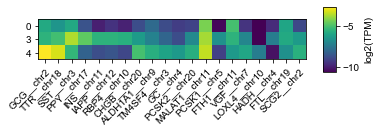

In [31]:
def heatmap_expression(expression_table, gene_selection, **kwargs):
    fig, ax = plt.subplots()
    im = ax.imshow(np.log(expression_table[gene_selection]), **kwargs)

    ax.set_xticks(np.arange(len(gene_selection)))
    ax.set_yticks(np.arange(len(expression_table.index)))
    ax.set_xticklabels(top_genes)
    ax.set_yticklabels(expression_table.index)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    cbar = ax.figure.colorbar(im, ax=ax, label='log2(TPM)', shrink=.3, aspect=5)
    return fig, ax
fig, ax = heatmap_expression(expressionstates, top_genes)

Conversely, genes that have large positive scores will be very similar between these clusters

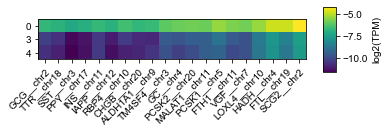

In [32]:
bottom_genes = genes[gene_importance_order[-n_top:]]

fig, ax = heatmap_expression(expressionstates, bottom_genes)